<a href="https://colab.research.google.com/github/telsayed/IR-in-Arabic/blob/master/Summer2021/labs/day6/IR_in_Arabic_Lab6_Query_Expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **IR in Arabic** - Summer 2021 lab day6



This is one of a series of Colab notebooks created for the **IR in Arabic** course. It demonstrates how we can employ query expansion to improve ranked retrieval and evaluate the output of multiple retrieval models.

The **learning outcomes** of the this notebook are:


*   Apply query expansion (**QE**) using the pseudo-relevance feedback (**PRF**) approach (with **RM3** as the term selection model).
*   Evaluate and compare the results of retrieval models with and without QE.
* Study the effect of parameter settings with QE.

### **Setup**

We will first install PyTerrier as follows:

In [ ]:
#install the PyTerrier framework
!pip install python-terrier

Since we need to apply QE, we need to install an additional PyTerrier package for pseudo-relevance feedback (**PRF**).

In [ ]:
# Need to install additional terrier package for PRF. It will take around 1 min
!git clone https://github.com/terrierteam/terrier-prf/
!apt-get install maven
%cd /content/terrier-prf/
!mvn install
!pwd
%cd ..

The next step is to initialise PyTerrier. This is performed using PyTerrier's init() method. The init() method is needed as PyTerrier must download Terrier's jar file and start the Java virtual machine. We prevent init() from being called more than once by checking started().

In [ ]:
import pyterrier as pt
if not pt.started():
  # In this lab, we need to specify that we start PyTerrier with PRF enabled
  pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])

Another library that we need for this lab is Arabic-Stopwords

In [ ]:
#install the Arabic stop words library
!pip install Arabic-Stopwords

We will import all the python libraries needed for this lab

In [ ]:
#we need to import the following libraries.
import pandas as pd
#to display the full text on the notebook without truncation
pd.set_option('display.max_colwidth', 150)
import numpy as np
import re
from snowballstemmer import stemmer
from tqdm import tqdm
import arabicstopwords.arabicstopwords as stp

### **Loading and Preparing Data**

We will prepare our helper functions for removing stop words, normalize, and stemming which we will use to process our queries.

**Reminder**: We need to apply the same preprocessing here that we applied when indexing our **EveTAR** dataset in previous labs.

In [ ]:
#removing Stop Words function
def remove_stop_words(sentence):
    terms=[]
    stopWords= set(stp.stopwords_list())
    for term in sentence.split() : 
        if term not in stopWords :
           terms.append(term)
    return " ".join(terms)

#a function to normalize the tweets
def normalize(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)

#define the stemming function
ar_stemmer = stemmer("arabic")
def stem(sentence):
    return " ".join([ar_stemmer.stemWord(i) for i in sentence.split()])
  

# perform all preprocessing steps
def preprocess(sentence):
  # apply preprocessing steps on the given sentence
  sentence = remove_stop_words(sentence)
  sentence = normalize(sentence)
  sentence = stem(sentence)
  return sentence

We will use our indexed **EveTAR** dataset. The index is uploaded in our Github repository so we will access it as follows:

In [ ]:
%rm -rf IR-in-Arabic
%rm -rf evetarIndex
!git clone https://github.com/telsayed/IR-in-Arabic.git 
!unzip IR-in-Arabic/Summer2021/data/EveTAR/evetarIndex.zip -d evetarIndex
!ls evetarIndex

Next, we will load our index.

In [ ]:
#we will load the index
index_ref = pt.IndexRef.of("./evetarIndex/data.properties")
index = pt.IndexFactory.of(index_ref)

Let's load our collection. We will later use it to read the full content of documents we retrieved from the index.

In [ ]:
dataset_links=["https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/tweets/evetar-q-01.txt",
               "https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/tweets/evetar-q-02.txt",
               "https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/tweets/evetar-q-03.txt",
               "https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/tweets/evetar-q-04.txt",
               "https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/tweets/evetar-q-05.txt",
               "https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/tweets/evetar-q-06.txt",
               "https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/tweets/evetar-q-07.txt",
               "https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/tweets/evetar-q-08.txt",
               "https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/tweets/evetar-q-09.txt",
               "https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/tweets/evetar-q-10.txt"]

full_data=pd.DataFrame()
for i in tqdm(range(len(dataset_links))):
    tweets=pd.read_csv(dataset_links[i], sep='\t')
    full_data=pd.concat([full_data,tweets],ignore_index=True)
full_data.reset_index(inplace=True,drop=True)
#the docno will be our tweetID
full_data["docno"]=full_data["tweetID"].astype(str)

We will load queries that are already defined and released with EveTAR dataset and process them using the same processing steps done when indexing EveTAR.

In [ ]:
#read the queries file from Github
topics=pd.read_csv("https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/topics.txt", sep='\t',names=['data'])
queries=[]
qid=[]
#we will get the queries and their ids from the topics file
for i in range(len(topics)):
    splitted=topics["data"][i:i+1][i].split(" ")
    if splitted[0]=="<title>":
       queries.append(' '.join(splitted[1:]))
    if splitted[0]=="<num>":
       qid.append(splitted[2])
queriesDF=pd.DataFrame() 
#the queries datframe should have qid and query columns to retrieve using PyTerrier      
queriesDF["qid"]=qid
queriesDF["raw_query"]=queries
#remove the stopwords from queries, do normalization, and apply stemming 
queriesDF["query"]=queriesDF["raw_query"].apply(preprocess)

We now load qrels (relevance judgments) so that we can evaluate our runs.

In [ ]:
# Loading EveTAR qrels
qrels=pd.read_csv("https://raw.githubusercontent.com/telsayed/IR-in-Arabic/master/Summer2021/data/EveTAR/qrels.txt", sep='\t',names=['qid','Q0','docno','label'])
qrels['docno']=qrels['docno'].astype(str)
qrels = qrels[qrels["docno"].isin(full_data["docno"].tolist())]

### **Experiments with PRF for QE**

Once we have all our data ready, now we can see how to query expansion using PRF process.

**Experiment 1: query expansion using RM3**

We will use BatchRetrieve PyTerrier class for retrieval using BM25 model. We will then apply query expansion using RM3 model and re-run the retrieval to see the effect of expansion.

**What is RM3?**

A relevance modelling (RM) approach to represent the topic described by the input query. RM3 benifits from a set of documents retrieved in response to that query, to generate a relevance model from which we can compute the probability of observing a term from these documents. Recall that the input query is one way to represent a topic, other representative terms can co-occur with these query terms. 
 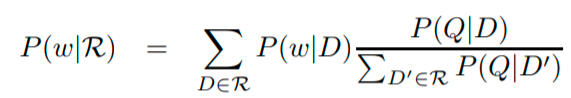
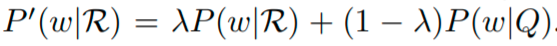

In [ ]:
# Define our retrieval model
bm25 = pt.BatchRetrieve(index, wmodel="BM25",num_results=1000)

Let's try a single query using BM25 as in earlier labs.

In [ ]:
query="هجوم انتحاري على مقهى في طرابلس في لبنان"

#we need to process the query also as we did for documents
query = preprocess(query)

#we will call the search function using our retrieval model we set up above
results_noqe = bm25.search(query)
if len(results_noqe)==0:
   print("There are no relevant documents for your selected query.")
else:
   print(results_noqe[['docid','score']][0:5])
#Let's check the tweets text for the top 5 retrieved tweets
full_data[['tweetText']][full_data['docno'].isin(results_noqe['docno'].loc[0:5].tolist())]

Let's now see the effect of query expansion on the query above. The process we will perform is as follows:


1. Retrieve an initial set of "psuedo-relevant documents" using a retrieval model (e.g., BM25). 
2. Use **RM3** method to score terms in these documents
3. Expand the current query with top terms from Step 2
4. Retrieve the final set of documents with the expanded query. 



In [ ]:
# "rewrite" function from PyTerrier will be used to expand queries specifying RM3 as the model
# fb_docs ==> no. expansion documents
# fb_terms ==> no. expansion terms
rm3_expander = pt.rewrite.RM3(index,fb_terms=10, fb_docs=100)

# Now we expand the query and see the resulting query
# For RM3, we need to first retrieve a set of "psuedo-relevant documents" then pass them to the expansion model
rm3_qe = bm25 >> rm3_expander
expanded_query = rm3_qe.search(query).iloc[0]["query"] #command will return the expanded query inside a dataframe with one row, access that row (iloc[0])

# Just print the expanded query with term scores
for s in expanded_query.split()[1:]:
  print(s)

# Let's compare to the original query
print("\n" + query)

In [ ]:
# After that you can search using the expanded query
expanded_query_formatted = ' '.join(expanded_query.split()[1:])
results_wqe = bm25.search(expanded_query_formatted)

if len(results_wqe)==0:
   print("There are no relevant documents for your selected query.")
else:
  print("   Before Expansion    After Expansion")
  print(pd.concat([results_noqe[['docid','score']][0:5].add_suffix('_1'),
            results_wqe[['docid','score']][0:5].add_suffix('_2')], axis=1).fillna(''))
   #print(results_wqe[['docid','score']][0:5])

#Let's check the tweets text for the top 5 retrieved tweets
full_data[['tweetText']][full_data['docno'].isin(results_wqe['docno'].loc[0:5].tolist())]

### **Retrieval with QE on all queries** 
We will now work on the full set of queries and the qrels (relevance judgements) provided with EveTAR.

In [ ]:
# We will run the full pipeline explained above. PyTerrier made it as easy as follows
rm3_pipe = bm25 >> rm3_expander >> bm25
pt.Experiment([bm25, rm3_pipe],
            queriesDF,
            qrels,
            ["map"],
            round={"map" : 4}, #"round" will round the score to 4 digits
            names=["BM25", "BM25+RM3"])

### **Comparing different PRF approaches using PyTerrier**

PyTerrier make it easy for us to compare between different PRF approaches. Let's compare 3 QE methods with the languag model retrieval model (Hiemstra_LM) from the last lab. 

In [ ]:
# We will run the full pipeline explained above. PyTerrier made it as easy as follows
lm_jm = pt.BatchRetrieve(index,wmodel="Hiemstra_LM",controls ={"c":0.7},num_results=1000)
rm3_pipe = lm_jm >> pt.rewrite.RM3(index, fb_terms=5, fb_docs=100) >> lm_jm
kld_pipe = lm_jm >> pt.rewrite.KLQueryExpansion(index, fb_terms=5, fb_docs=100) >> lm_jm
bo1_pipe = lm_jm >> pt.rewrite.Bo1QueryExpansion(index,fb_terms=5, fb_docs=100) >> lm_jm

pt.Experiment([lm_jm, rm3_pipe, kld_pipe, bo1_pipe],
            queriesDF,
            qrels,
            ["map"],
            round={"map" : 4},
            names=["LM", "LM+RM3","LM+KLD","LM+Bo1"])

## **Exercise1**
Study the effect of changing the number of feedback terms and documents on PRF using RM3 for term selection and BM25 as the retrieval model. Use the following ranges:
*   feedback terms (fb_terms): {5,10}
*   feedback documents (fb_docs): {10,30}

**Hints**:
* Don't forget to do all combinations.
* Compare to the performance to original BM25
* Display number of queries improved/degraded by applying QE (check PyTerrier [here](https://pyterrier.readthedocs.io/en/latest/experiments.html#significance-testing)).

In [ ]:
# Exercise 1

## **Exercise 2**
In this exercise, we are asking you to implement your own QE approach using PRF following these steps for each query in EveTAR.
1.   Retrieve initial set of pseudo-relevant documents.
2.   Score and select expansion terms.
3.   Expand the query using selected terms.
4.   Retrieve final set of documents using expanded query.



**Detailed instructions:**
* For feedback term selection, use sum of tf-idf scores for each term from the top *k* documents as your term scoring function.
* Use any retrieval model you like as your base model.
* Make the number of feedback documents and terms paramters so that you can change them as you like.
* Test your method as shown in Exercise 1 and compare it to existing QE methods covered today.  

**Below are the suggested steps:**
1. Implement your terms scoring method. The method should take: the initial set of retrieved documents for a query and the index as input, and should return unique terms with scores.
2. Implement a method that accepts a query, scored feedback terms, and number of expansion terms and then returns expanded query.
3. Implement a third main function that does all PRF steps using the previous two helper functions.

In [ ]:
# Exercise 2

## **References**


* [PyTerrier  retrieval and evaluation notebook](https://github.com/terrier-org/pyterrier/blob/master/examples/notebooks/retrieval_and_evaluation.ipynb).
*   [PyTerrier documentation.](https://pyterrier.readthedocs.io/_/downloads/en/latest/pdf/)

